In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [43]:
import sklearn
print(sklearn.__version__)

1.5.2


In [44]:
df= pd.read_csv("Resale flat prices based on registration date from Jan-2017 onwards.csv")

In [45]:
# Preprocessing
# Convert 'remaining_lease' to numerical format (total months)
def parse_remaining_lease(lease):
    try:
        years, months = map(int, lease.replace(' years', '').replace(' months', '').split())
        return years * 12 + months
    except:
        return np.nan
    
# Convert 'storey_range' to average storey
def parse_storey_range(storey):
    try:
        start, end = map(int, storey.split(" TO "))
        return (start + end) / 2
    except:
        return np.nan

In [46]:
df['remaining_lease_months'] = df['remaining_lease'].apply(parse_remaining_lease)
df['average_storey'] = df['storey_range'].apply(parse_storey_range)

In [47]:
# Feature Engineering: Adding new features
current_year = 2025  # Adjust based on current year
df['flat_age'] = current_year - df['lease_commence_date']
df['price_per_sqm'] = df['resale_price'] / df['floor_area_sqm']
df['remaining_lease_ratio'] = df['remaining_lease_months'] / (99 * 12)  # 99 years in months

In [48]:
categorical_features = ['town', 'flat_type', 'flat_model']
label_encoders = {}

In [49]:
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [50]:
# Visualize outliers using scatter plot and box plot before data cleaning
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0, 0.5, 'Resale Price')

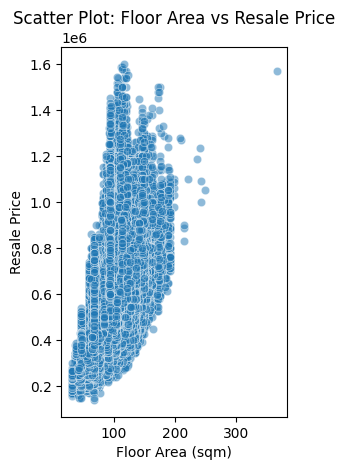

In [51]:
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='floor_area_sqm', y='resale_price', alpha=0.5)
plt.title("Scatter Plot: Floor Area vs Resale Price")
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Resale Price")

Text(0, 0.5, 'Resale Price')

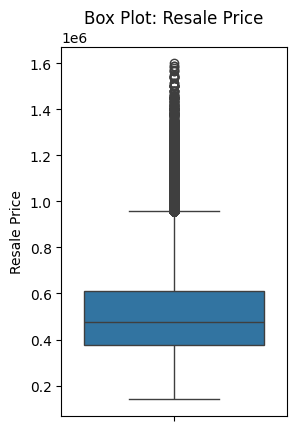

In [52]:
plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='resale_price')
plt.title("Box Plot: Resale Price")
plt.ylabel("Resale Price")

In [53]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [54]:
# Drop unnecessary columns
columns_to_drop = ['month', 'block', 'street_name', 'remaining_lease', 'storey_range']
df = df.drop(columns=columns_to_drop)

In [55]:
# Handle missing values
df = df.dropna()

In [56]:
# Select features for the model
selected_features = ['town', 'flat_type', 'floor_area_sqm', 'flat_model', 'flat_age',
                     'remaining_lease_months', 'average_storey', 'price_per_sqm', 'remaining_lease_ratio']
X = df[selected_features].to_numpy()
y = df['resale_price'].to_numpy()

In [57]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [58]:
# Separate features (X) and target (y)
X = df.drop('resale_price', axis=1).to_numpy()
y = df['resale_price'].to_numpy()

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

In [60]:
# Train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=25)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=25)

In [61]:
# Predict on test data
y_pred = gbr.predict(X_test)

In [62]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 86635894.7060597
Root Mean Squared Error: 9307.84049638044


In [63]:
import joblib

# Save the trained Gradient Boosting Regressor model
joblib.dump(gbr, "gbr_model.pkl")

# Save the StandardScaler used for scaling
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully!")


Model and scaler saved successfully!
